In [1]:
## Imports
import sys
import os
import time
import math
import random

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
import plot_utils
import notebook_utils_2

from sklearn.metrics import roc_curve, auc

In [2]:
# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"neutron", 1:"e"}

# Fix the colour scheme for each particle type
COLOR_DICT = {"neutron":"red", "e":"blue"}

In [3]:
def plot_log(run_ids, model_ids, model_cls, keys, dumps_path, lgd_loc=(0.8,0.5), val=False, log=False, show=False, save_path=None):
    """Plot the logs for any model from saved .csv files
    
    Args:
    run_ids    -- List of run ids e.g. ["20191202_171757", ...] for each model to be plotted
    model_ids  -- Names of the models for which the log is being plotted
    model_cls  -- Two colors for each model for one axis on each size of the plot
    keys       -- Two keys for columns in the dataframe to plot (To generalize to the VAE)
    dumps_path -- Absolute path to the global dump folder
    log        -- Boolean to determine whether to use (log scaling) or not
    lgd_loc    -- Tuple to determine the location of the legend
    show       -- Boolean to determine whether to call plt.show()
    save_path  -- Absolute path of the location at which to save the plot
    """
    
    # Defensive assertions to prevent Nonetype error
    assert run_ids is not None
    assert model_ids is not None
    assert model_cls is not None
    assert dumps_path is not None
    
    # Defensive assertion to prevent breaking function usage
    assert len(run_ids) == len(model_ids)
    assert len(model_ids) == len(model_cls)
    assert len(keys) == 2
    
    # Extract the values stored in the .csv files
    train_epochs = []
    val_epochs = []
    
    train_0 = []
    train_1 = []
    
    val_0 = []
    val_1 = []
    
    dumps_path = dumps_path + "/" if not dumps_path.endswith("/") else dumps_path
    dump_dirs = [dumps_path + run_id + "/" for run_id in run_ids]
    
    # Iterate over the logs for all the models
    for dump_dir in dump_dirs:
        
        train_log_path = dump_dir + "log_train.csv"
        val_log_path = dump_dir + "log_val.csv"
        
        if os.path.exists(train_log_path) and os.path.exists(val_log_path):
            train_log_df = pd.read_csv(train_log_path, usecols=["epoch",keys[0],keys[1]])
            if val:
                val_log_df = pd.read_csv(val_log_path, usecols=["epoch",keys[0],keys[1]])
            
        train_epochs.append(train_log_df["epoch"].values)
        train_0.append(train_log_df[keys[0]].values)
        train_1.append(train_log_df[keys[1]].values)
        
        if val:
            val_epochs.append(val_log_df["epoch"].values)
            val_0.append(val_log_df[keys[0]].values)
            val_1.append(val_log_df[keys[1]].values)
     
    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(16,11))
    ax2 = ax1.twinx()
    
    # Print the mpl rcParams
    mpl.rcParams['agg.path.chunksize']=1e12
    
    # Reload the backend
    mpl.use(mpl.get_backend())
    
    for i, model_ids in enumerate(model_ids):
        if val:
            ax1.plot(train_epochs[i], train_0[i], color=model_cls[i][0], alpha=0.3, linewidth=1.0)
            ax2.plot(train_epochs[i], train_1[i], color=model_cls[i][1], alpha=0.3, linewidth=1.0)
            
            ax1.plot(val_epochs[i], val_0[i], color=model_cls[i][0], label=model_ids+" "+keys[0], alpha=1.0, linewidth=1.0)
            ax2.plot(val_epochs[i], val_1[i], color=model_cls[i][1], label=model_ids+" "+keys[1], alpha=1.0, linewidth=1.0)
        else:
            ax1.plot(train_epochs[i], train_0[i], color=model_cls[i][0], label=model_ids+" "+keys[0], alpha=0.3, linewidth=1.0)
            ax2.plot(train_epochs[i], train_1[i], color=model_cls[i][1], label=model_ids+" "+keys[1], alpha=0.3, linewidth=1.0)
    
    if log:
        ax1.set_yscale("log")
        ax2.set_yscale("log")
    
    # Setup plot characteristics
    ax1.tick_params(axis="x", labelsize=30)
    ax1.set_xlabel("Epoch", fontsize=30)
    
    ax1.set_ylabel(keys[0], fontsize=30, color=model_colors[0][0])
    ax1.tick_params(axis="y", labelsize=30, color=model_colors[0][0])
    
    ax2.set_ylabel(keys[1], fontsize=30, color=model_colors[0][1])
    ax2.tick_params(axis="y", labelsize=30, color=model_colors[0][1])
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    lgd = plt.legend(lines1 + lines2, labels1 + labels2, prop={"size":30},
                     loc="upper right", bbox_to_anchor=lgd_loc, frameon=True,
                     fancybox=True, shadow=True, framealpha=1.0)
    
    ax1.grid(True, which="both", axis="both")
    ax2.grid(True, which="both", axis="both")
    
    plt.margins(0.2)
    
    if save_path is not None:
#         plt.savefig(save_path, format='pdf', dpi=600, bbox_extra_artists=(lgd))
        plt.savefig(save_path)
    if show:
        try:
            plt.show()
        except:
            print("plot_log() : Unable to render the plot due to limits on \'agg.path.chunksize\')")
            if save_path is None:
                print("plot_log() : Saving plot to ./{0}".format("vae_training_log.pdf"))
                plt.savefig(save_path, format='pdf', dpi=600, bbox_extra_artists=(lgd))
            plt.clf()
            plt.close()
    else:
        plt.clf()
        plt.close()

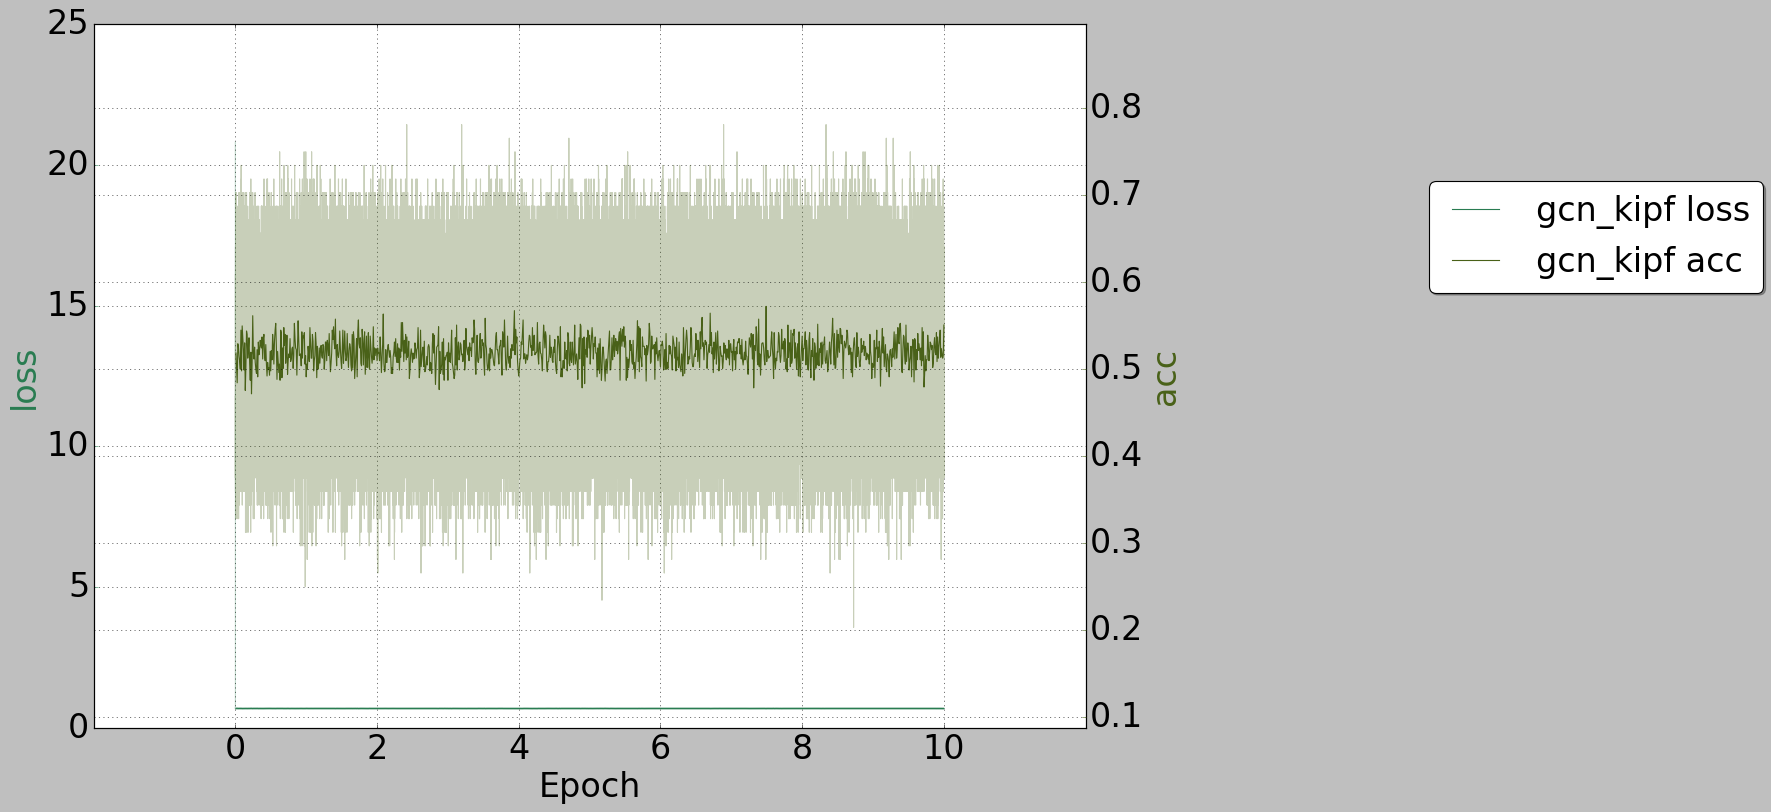

In [4]:
dumps_path = "/home/jwalker/data/NeutronGNN/dump/"
run_ids = [["gcn_kipf20200203_151411"]]
model_ids = [["gcn_kipf"]]

for run_id, model_id in zip(run_ids, model_ids):
    model_colors = [(np.random.rand(3,), np.random.rand(3,)) for model in model_id]
    keys = ["loss", "acc"]
    
    save_path = os.path.join(dumps_path, run_id[0], "train_prog.png")
    plot_log(run_id, model_id, model_colors, keys, dumps_path, lgd_loc=(1.7, 0.8), 
             val=True, log=False, show=True, save_path=save_path)